# Heuristic Optimization

In [1]:
import soiling_model.cleaning_optimization as co
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import (rcParams,dates,colors)
rcParams['figure.figsize'] = (15, 7)

In [2]:
d = "data/public/" 
params = d+"parameters.xlsx"
weather = d+'woomera_data.xlsx'
SF = d+'SF_woomera_SolarPILOT.csv'            # solar field of 48 sectors located in Woomera
climate_file = d+'woomera_location_modified.epw'
n_az = 8        # number of azimuth partitions for the field sectors
n_rad = 6       # number of radial partitions for the field sectors
n_sol_az = 10   # number of solar azimuth angles for the efficiency lookup table
n_sol_el = 10   # number of solar elevation angles for the efficiency lookup table
second_surface = False # second_surface = False uses a first-surface model for the reflectance loss
n_sectors_cleaned_per_truck = 1 # number of sectors cleaned in a day by one truck

Build soiling model, import inputs, and sectorize the field

Importing constants
Importing full solar field and sectorizing with 8 angular and 6 radial sectors
Importing site data (weather,time). Using dust_type = PM10, test_length = 8760 hours
Length of simulation for file data/public/woomera_data.xlsx: 365.0 days
No rain intensity data to import.
Importing relative humidity data...
Importing dust properties for each experiment
Added PM10 attribute to dust class to all experiment dust classes
Calculating sun apparent movement and angles for 1 simulations
Calculating heliostat movement and angles for 1 simulations
First surface model
No value for hrz0 supplied. Using value in self.hrz0 = 50.0.
Calculating deposition velocity for each of the 1 simulations
Aerodynamic resistance is considered
Calculating adhesion/removal balance
  Using common stow_tilt. Assumes all heliostats are stored at helios.stow_tilt at night.
Loss Model is geometry. Setting extinction coefficients to unity for all heliostats in all files.
Calculating soil deposited in a ti

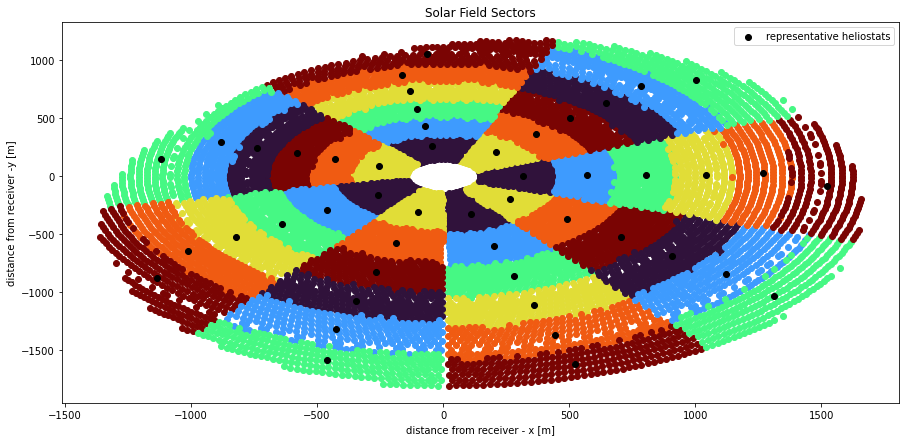

In [3]:
sec = (n_rad,n_az)
opt = co.optimisation_problem(params,SF,weather,climate_file,sec,dust_type="PM10",\
    second_surface=second_surface,n_az=n_sol_az,n_el=n_sol_el,verbose=True)
opt.field_model.helios.sector_plot()

Grid search number of trucks and annual cleans to optimize cleaning resources and frequencies.

In [4]:
helio_area = opt.field_model.helios.height*opt.field_model.helios.width
n_helios = opt.field_model.helios.full_field['x'].shape[0]
area_per_sector = n_helios/n_az/n_rad*helio_area
opt.truck = {   'operator_salary':80e3,
                'operators_per_truck_per_day':4,
                'purchase_cost':150e3,
                'maintenance_costs':15e3,
                'useful_life': 4,
                'fuel_cost': 0.005*area_per_sector,
                'water_cost': 0.005*area_per_sector
            }
opt.electricty_price = 50/1e6
opt.plant_other_maintenace = 0.0
opt.plant.receiver['thermal_max'] = 1e3 # MW
opt.plant.receiver['thermal_min'] = 105 # MW

Optimize via grid search on number of trucks and number of field cleans in a year

In [5]:
Nt = range(1,10)
Nc = range(1,51)
TCC = np.nan*np.ones((len(Nt),len(Nc)))
for ii in range(len(Nt)):
    n_trucks = Nt[ii]
    for jj in range(len(Nc)):
        n_cleans = Nc[jj]
        # print("Simulating {0:d} trucks with {1:d} cleans".format(n_trucks,n_cleans))
        results = co.periodic_schedule_tcc(opt,n_trucks,n_cleans,\
            n_sectors_per_truck=n_sectors_cleaned_per_truck,verbose=False)
        number_of_cleaning_finishes = results['cleaning_actions'][0].sum(axis=1)[-1]
        if  number_of_cleaning_finishes < n_cleans:
            print("Cleans maxed out")
            break
        else:
            TCC[ii,jj] = results['total_cleaning_costs']

Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out
Cleans maxed out


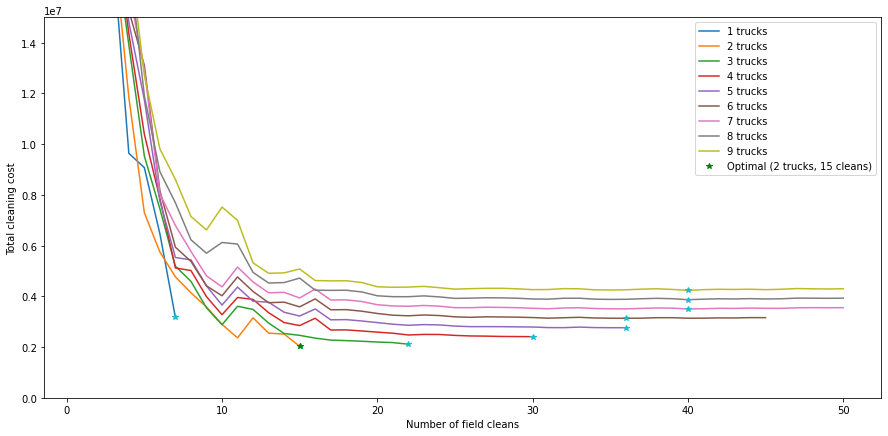

In [6]:
fig,ax = plt.subplots()
num_cleans = np.arange(start=Nc[0],stop=Nc[-1]+1)
for ii in Nt:
    ax.plot(num_cleans,TCC[ii-1,:],label=str(ii)+" trucks")

# optimal for each number of trucks
nc_opt = np.nanargmin(TCC,axis=1)
ax.plot(num_cleans[nc_opt],TCC[range(len(Nt)),nc_opt],linestyle="None",marker='*')

# overall optimal
nc_opt = np.nanargmin(TCC)
r,c = np.unravel_index(nc_opt,TCC.shape)
label_str = "Optimal ({0:d} trucks, {1:d} cleans)".format(r+1,c+1)
ax.plot(num_cleans[c],TCC[r,c],color='green',linestyle="None",marker='*',label=label_str)

ax.set_xlabel("Number of field cleans")
ax.set_ylabel("Total cleaning cost")
ax.set_ylim((0,15e6))
ax.legend()

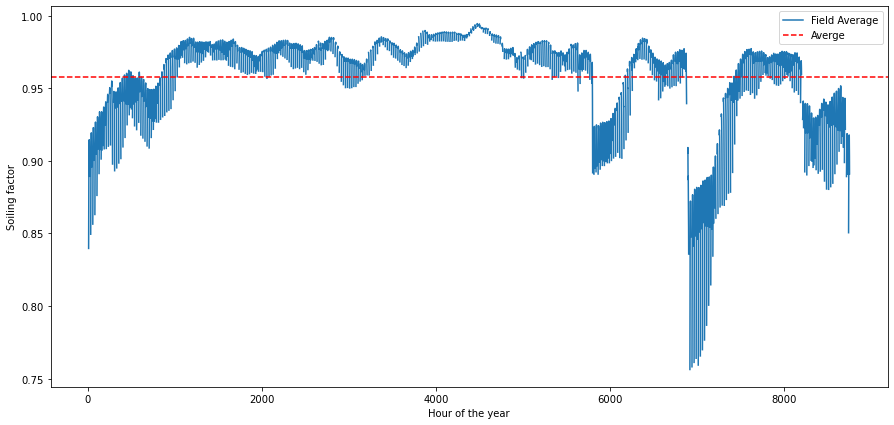

In [7]:
results_opt = co.periodic_schedule_tcc(opt,r+1,c+1,\
    n_sectors_per_truck=n_sectors_cleaned_per_truck,verbose=False)
nh,nt = results['soiling_factor'][0].shape
fig,ax = plt.subplots()
sf = results['soiling_factor'][0]
ax.plot(sf.mean(axis=0),label="Field Average")
ax.plot(nt-1,sf[:,0].mean(),'*')
ax.plot(0,sf[:,-1].mean(),'*')
ax.axhline(y=np.nanmean(sf),color='red',ls='--',label="Averge")
ax.set_xlabel("Hour of the year")
ax.set_ylabel("Soiling factor")
ax.legend()


Results for optimum

In [8]:
cleans = results_opt['cleaning_actions'][0] # same for all runs
"Number of cleans: {0:.1f}".format(cleans.sum())

'Number of cleans: 720.0'

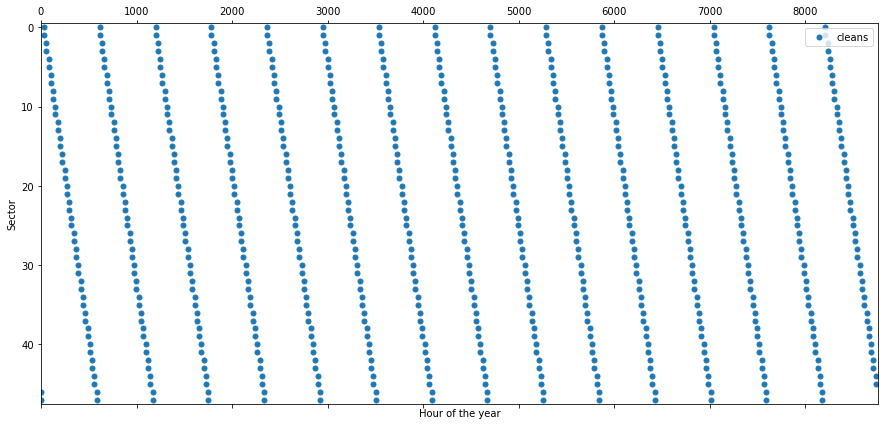

In [9]:
N_sectors = n_az*n_rad
ax = plt.subplot()
ax.spy(cleans,aspect='auto',marker='.',label="cleans")
ax.set_xlabel("Hour of the year")
ax.set_ylabel("Sector")
ax.legend()